In [48]:
from json import loads
from pyspark.sql import SparkSession
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
from pyspark.sql.functions import col,from_json,udf,split,explode,lit,array
from pyspark.ml.feature import NGram
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,MapType,FloatType,ArrayType
import numpy as np

In [3]:
spark = SparkSession.\
        builder.\
        appName("ml").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1024m").\
        getOrCreate()

22/12/08 15:07:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
df = pd.read_csv('data/dataLabel.csv')

In [5]:
test = df[~pd.isna(df['true_label'])].reset_index(drop=True)
train = df[pd.isna(df['true_label'])].reset_index(drop=True)

In [6]:
test['true_label'] = test['true_label'].astype('int')

In [7]:
train = train.drop(columns=['true_label'])

In [8]:
df_test = spark.createDataFrame(test)
df_train = spark.createDataFrame(train)

In [10]:
df_test.write.partitionBy("label").mode('overwrite').parquet('hdfs://namenode:9000/ml/test_data')

In [11]:
df_train.write.partitionBy("label").mode('overwrite').parquet('hdfs://namenode:9000/ml/train_data')

22/12/08 15:07:42 WARN TaskSetManager: Stage 3 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.


Lexicon-based sentiment analysis

In [14]:
df = df_train.withColumn('comment_term',split(df_train.clean_content, ' ', -1))
def getNGram(n):
    ngram = NGram(n=n)
    ngram.setInputCol("comment_term")
    ngram.setOutputCol("nGrams")
    df_nGram = ngram.transform(df)
    result_nGram = df_nGram.withColumn('word',explode(df_nGram.nGrams))\
        .groupBy(['label','word'])\
        .count()
    return result_nGram
result_nGram = getNGram(1)

In [15]:
for i in range(3):
    result_nGram.filter(result_nGram.label == i).orderBy(col("count").desc()).toPandas().to_csv(f'sample/{i}.csv',index=False)

22/12/08 15:11:03 WARN TaskSetManager: Stage 4 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 15:11:13 WARN TaskSetManager: Stage 9 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 15:11:18 WARN TaskSetManager: Stage 14 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.


In [16]:
pst_word = {}
ngt_word = {}
with open('vi_sentiment/positive_words_vi.txt','r') as f:
    for line in f:
        line = line.replace('\n','')
        if line not in pst_word:
            pst_word[line] = 1
with open('vi_sentiment/negative_words_vi.txt','r') as f:
    for line in f:
        line = line.replace('\n','')
        if line not in pst_word:
            ngt_word[line] = 1

In [17]:
def check(sentent):
    list_token = sentent.split(' ')
    res = 0
    for token in list_token:
        if token in pst_word:
            res += 1
        elif token in ngt_word:
            res -= 1
    if res > 0:
        return 2
    elif res == 0:
        return 1
    else:
        return 0

In [18]:
def value_check(sentent):
    list_token = sentent.split(' ')
    pos = 0
    neg = 0
    for token in list_token:
        if token in pst_word:
            pos += 1
        elif token in ngt_word:
            neg += 1
    return round((pos - neg)/ (pos + neg + 1e-6),3)

In [19]:
spark.udf.register("check", check,IntegerType())
spark.udf.register("value_check", value_check,FloatType())

<function __main__.value_check(sentent)>

Find Best Param

In [43]:
df_train.createOrReplaceTempView("train_data")

In [65]:
result_train = spark.sql("""
    select label,value_check(clean_content) score from train_data
""")

In [66]:
result_train = result_train.toPandas()

22/12/08 16:20:31 WARN TaskSetManager: Stage 23 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.


In [67]:
def f(row,val):
    if row['score'] > val:
        res = 2
    elif row['score'] < -val:
        res = 0
    else:
        res = 1
    return res

In [93]:
list_val = np.linspace(0,0.5,21)
list_acc = []
for val in list_val:
    result_train['prediction'] = result_train.apply(f,val=val,axis=1)
    list_acc.append(result_train[result_train['label']== result_train['prediction']].shape[0]*100/result_train.shape[0])

([<matplotlib.axis.XTick at 0x7f6b6d41e130>,
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.025'),
  Text(2, 0, '0.05'),
  Text(3, 0, '0.075'),
  Text(4, 0, '0.1'),
  Text(5, 0, '0.125'),
  Text(6, 0, '0.15'),
  Text(7, 0, '0.175'),
  Text(8, 0, '0.2'),
  Text(9, 0, '0.225'),
  Text(10, 0, '0.25'),
  Text(11, 0, '0.275'),
  Text(12, 0, '0.3'),
  Text(13, 0, '0.325'),
  Text(14, 0, '0.35'),
  Text(15, 0, '0.375'),
  Text(16, 0, '0.4'),
  Text(17, 0, '0.425'),
  Text(18, 0, '0.45'),
  Text(19, 0, '0.475'),
  Text(20, 0, '0.5')])

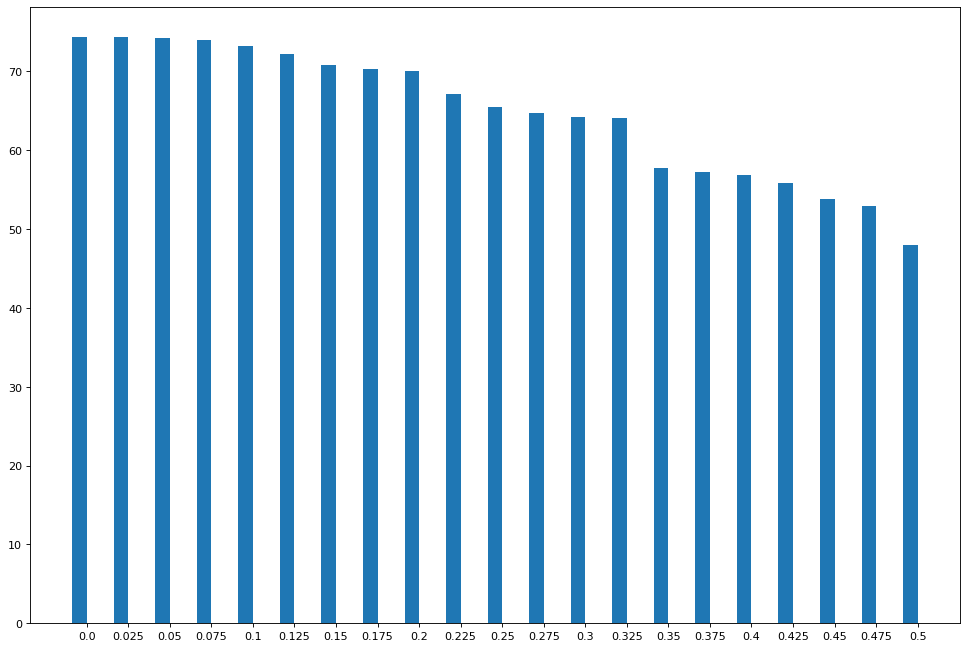

In [96]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)

labels = [str(round(x,3)) for x in list_val]
x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

plt.bar(x - width/2,width=width,height= list_acc)
plt.xticks(x,labels)

In [100]:
p_max = np.argmax(list_acc)

In [102]:
df_test.createOrReplaceTempView("test_data")

In [104]:
result_test = spark.sql("""
    select true_label,label,value_check(clean_content) score from tmp
""")

In [105]:
result_test =  result_test.toPandas()

In [106]:
result_test['prediction'] = result_test.apply(f,val=p_max,axis=1)

In [107]:
result_test[result_test['true_label']== result_test['prediction']].shape[0]/result_test.shape[0]

0.7217199115933293

In [118]:
result_test[result_test['label']== result_test['prediction']].shape[0]/result_test.shape[0]

0.7486437613019892

In [108]:
from sklearn.metrics import classification_report
print(classification_report(result_test.true_label, result_test.prediction))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       805
           1       0.15      0.13      0.14       538
           2       0.84      0.87      0.86      3634

    accuracy                           0.72      4977
   macro avg       0.49      0.48      0.49      4977
weighted avg       0.71      0.72      0.71      4977



In [115]:
result_train['prediction'] = result_train.apply(f,val=p_max,axis=1)

In [116]:
match_train = result_train[result_train['label']== result_train['prediction']].shape[0]
match_test = result_test[result_test['label']== result_test['prediction']].shape[0]

In [117]:
(match_train + match_test)/(result_train.shape[0] + result_test.shape[0])

0.7443827511240674

In [8]:
dataset_train = df_train.select(split(df_train.clean_content, ' ').alias('cmt_token'),'rating', 'label')
dataset_test = df_test.select(split(df_test.clean_content, ' ').alias('cmt_token'),'rating', 'label','true_label')

In [9]:
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import lower, col, split

# dataset_train = df_train.select(split(df.clean_content, ' ').alias('cmt_token'),'rating', 'label')

word2Vec = Word2Vec(vectorSize=100, seed=42, inputCol="cmt_token", outputCol="features")
word2Vec.setMaxIter(5)
model = word2Vec.fit(dataset_train)

22/12/08 13:26:28 WARN TaskSetManager: Stage 0 contains a task of very large size (22335 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:26:37 WARN TaskSetManager: Stage 2 contains a task of very large size (22335 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:36:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/08 13:36:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [11]:
train_set = model.transform(dataset_train)
test_set = model.transform(dataset_test)

In [110]:
train_set.groupby('label').count().show()

22/12/07 17:02:19 WARN TaskSetManager: Stage 66 contains a task of very large size (22335 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+
|label| count|
+-----+------+
|    0| 38977|
|    1| 17394|
|    2|262518|
+-----+------+



In [12]:
train_set_0 = train_set.filter(col('label') ==0)
train_set_1 = train_set.filter(col('label') ==1)
train_set_2 = train_set.filter(col('label') ==2)

In [13]:
cnt_0 = train_set.filter(col('label') ==0).count()
cnt_1 = train_set.filter(col('label') ==1).count()
cnt_2 = train_set.filter(col('label') ==2).count()

22/12/08 13:37:23 WARN TaskSetManager: Stage 17 contains a task of very large size (22335 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:37:23 WARN TaskSetManager: Stage 19 contains a task of very large size (22335 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:37:24 WARN TaskSetManager: Stage 21 contains a task of very large size (22335 KiB). The maximum recommended task size is 1000 KiB.


In [14]:
a = range(int(cnt_2/cnt_0) + 2)
b = range(int(cnt_2/cnt_1) + 2)

In [15]:
a,b

(range(0, 8), range(0, 17))

In [16]:
# duplicate the minority rows
train_set_0 = train_set_0.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
train_set_1 = train_set_1.withColumn("dummy", explode(array([lit(x) for x in b]))).drop('dummy')

In [17]:
combined_df = train_set_0.unionAll(train_set_1).unionAll(train_set_2)

In [18]:
combined_df.groupby('label').count().show()

22/12/08 13:37:26 WARN TaskSetManager: Stage 23 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+
|label| count|
+-----+------+
|    0|311816|
|    1|295698|
|    2|262518|
+-----+------+



In [82]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [84]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(combined_df)

featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(combined_df)

# (trainingData, testData) = self.data.randomSplit([0.7, 0.3])

rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees= 250 ,maxDepth = 10)

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

model = pipeline.fit(combined_df)

22/12/08 12:39:56 WARN TaskSetManager: Stage 68 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 12:40:00 WARN TaskSetManager: Stage 70 contains a task of very large size (22264 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 12:40:26 WARN TaskSetManager: Stage 72 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 12:40:31 WARN TaskSetManager: Stage 74 contains a task of very large size (22264 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 12:41:07 WARN TaskSetManager: Stage 76 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 12:41:07 WARN TaskSetManager: Stage 77 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 12:41:12 WARN TaskSetManager: Stage 78 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

In [35]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovr = OneVsRest(classifier=lr)
ovrModel = lr.fit(combined_df)
predictions = ovrModel.transform(test_set)

22/12/08 13:45:18 WARN TaskSetManager: Stage 143 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:45:26 WARN TaskSetManager: Stage 145 contains a task of very large size (22264 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:45:30 WARN TaskSetManager: Stage 147 contains a task of very large size (22264 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:45:33 WARN TaskSetManager: Stage 149 contains a task of very large size (22264 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:45:37 WARN TaskSetManager: Stage 151 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:45:41 WARN TaskSetManager: Stage 153 contains a task of very large size (22336 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 13:45:45 WARN TaskSetManager: Stage 155 contains a task of very large size (22336 KiB). The maximum recommended task size is 10

In [ ]:
lr

In [40]:
predictions = ovrModel.transform(test_set)

In [43]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [85]:
# predictioxns = model.transform(test_set)

In [45]:
result_test = predictions.select('true_label', 'prediction')
# result_test = result_test.withColumnRenamed('predictedLabel', 'prediction')

In [47]:
# result_test = predictions.select('true_label', 'predictedLabel')
# result_test = result_test.withColumnRenamed('predictedLabel', 'prediction')

In [48]:
result_test[['true_label','prediction']].toPandas()

,true_label,prediction
0,2,2.0
1,0,0.0
2,2,2.0
3,2,2.0
4,0,2.0
...,...,...
4930,2,2.0
4931,2,2.0
4932,2,2.0
4933,1,1.0


In [49]:
result_test =  result_test[['true_label','prediction']].toPandas()

In [50]:
result_test['prediction'] = result_test['prediction'].astype('int')

In [51]:
result_test[result_test['true_label']== result_test['prediction']].shape[0]/result_test.shape[0]

0.7860182370820669

In [52]:
from sklearn.metrics import classification_report

In [53]:
from sklearn.metrics import classification_report
print(classification_report(result_test.true_label, result_test.prediction))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       767
           1       0.35      0.62      0.44       546
           2       0.94      0.83      0.88      3622

    accuracy                           0.79      4935
   macro avg       0.66      0.72      0.68      4935
weighted avg       0.84      0.79      0.81      4935

